# MELGAN

In [3]:
!nvidia-smi

Wed Oct 12 04:47:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install tensorflow_addons
!pip install tensorflow_io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 2.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.0 MB 1.2 MB/s 


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import soundfile as sf
import matplotlib.pyplot as plt
import tensorflow_io as tfio

from pathlib import Path

from IPython.lib.display import Audio

## LS Dataset

In [6]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
!tar -xf /content/LJSpeech-1.1.tar.bz2

--2022-10-12 04:47:43--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 174.138.79.61
Connecting to data.keithito.com (data.keithito.com)|174.138.79.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [application/octet-stream]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  16.1MB/s    in 2m 46s  

2022-10-12 04:50:29 (15.8 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



### Create Dataset

In [7]:
wavs = tf.io.gfile.glob("./LJSpeech-1.1/wavs/*.wav")
print(f"Number of audio files: {len(wavs)}")

Number of audio files: 13100


In [8]:
audio_data, sample_rate = sf.read(wavs[1], dtype='float32')
Audio(audio_data, rate=sample_rate)

sample rate: 22050


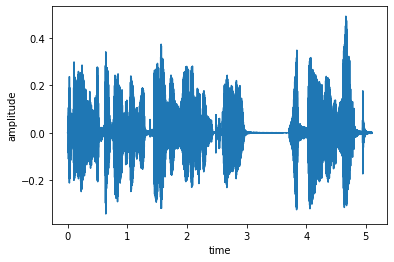

In [9]:
print(f"sample rate: {sample_rate}")
plt.plot(np.arange(0, len(audio_data) / sample_rate, 1/sample_rate), audio_data)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.show();

In [10]:
NUM_SECONDS = 2
DESIRED_SAMPLES = int(2**np.ceil(np.log2(sample_rate*NUM_SECONDS)))
print(f"desired samples: {DESIRED_SAMPLES}")

desired samples: 65536


In [11]:
DESIRED_SAMPLES/sample_rate

2.972154195011338

In [12]:
# Mapper function for loading the audio. This function returns two instances of the wave
def preprocess(filename):
  audio = tf.audio.decode_wav(tf.io.read_file(filename), 1, DESIRED_SAMPLES).audio
  return audio, audio

### Toy Dataset

In [13]:
# Create tf.data.Dataset objects and apply preprocessing
toy_samples = 4
wavs = tf.io.gfile.glob("LJSpeech-1.1/wavs/*.wav")
toy_wavs = wavs[:toy_samples]
toy_dataset = tf.data.Dataset.from_tensor_slices((toy_wavs,))
toy_dataset = toy_dataset.map(map_func = preprocess, num_parallel_calls=tf.data.AUTOTUNE)
toy_dataset

<ParallelMapDataset element_spec=(TensorSpec(shape=(65536, 1), dtype=tf.float32, name=None), TensorSpec(shape=(65536, 1), dtype=tf.float32, name=None))>

Full Dataset

In [14]:
# Create tf.data.Dataset objects and apply preprocessing
wavs = tf.io.gfile.glob("LJSpeech-1.1/wavs/*.wav")
train_dataset = tf.data.Dataset.from_tensor_slices((wavs,))
train_dataset = train_dataset.map(map_func = preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset

<ParallelMapDataset element_spec=(TensorSpec(shape=(65536, 1), dtype=tf.float32, name=None), TensorSpec(shape=(65536, 1), dtype=tf.float32, name=None))>

## Model Blocks

### Mel Spectrogram Layer

In [15]:
class MelSpectrogram(tf.keras.layers.Layer):
    def __init__(self, 
                 sample_rate=22050, 
                 frame_length=1024, 
                 frame_step=256, 
                 fft_length=None,
                 #fft_length=1024, 
                 num_mel_bins=80, 
                 f_min=125, 
                 #f_max=3800,
                 f_max=7600,
                 **kwargs):
        super().__init__(**kwargs)
        self.sample_rate = sample_rate
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.fft_length = fft_length
        self.num_mel_bins = num_mel_bins
        self.f_min = f_min
        self.f_max = f_max
        self.linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins = self.num_mel_bins,
                                                                                 num_spectrogram_bins = self.frame_length // 2 + 1,
                                                                                 sample_rate = self.sample_rate,
                                                                                 lower_edge_hertz = self.f_min,
                                                                                 upper_edge_hertz = self.f_max)
    def call(self, audio, training=True):
        if training:
            stfts = tf.signal.stft(tf.squeeze(audio, -1), 
                                   frame_length=self.frame_length, 
                                   frame_step=self.frame_step, 
                                   fft_length=self.fft_length, 
                                   pad_end=True)
            #stfts = tf.abs(stfts)
            mel_spectrograms = tf.matmul(tf.abs(stfts), self.linear_to_mel_weight_matrix)
            return tf.math.log(mel_spectrograms + 1e-6)
        else:
            return audio

In [16]:
mel_layer = MelSpectrogram()

In [17]:
for audio_mb in toy_dataset:
    x_mb, y_mb = audio_mb
    spectogram = mel_layer(x_mb)
spectogram.shape

TensorShape([256, 80])

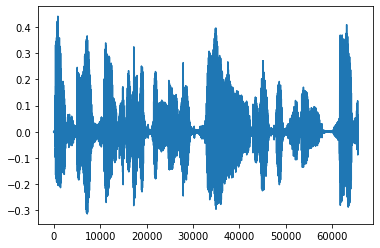

In [18]:
plt.plot(np.squeeze(audio_mb[0].numpy()))

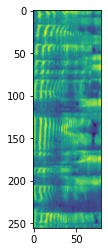

In [19]:
plt.imshow(spectogram)

### Residual Block

In [20]:
def residual_stack(x, filters):
    residual = x
    # block
    x = tf.keras.layers.LeakyReLU()(x)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Conv1D(filters, 3, padding="same", dilation_rate=1),
                                       data_init=False)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Conv1D(filters, 3, padding="same", dilation_rate=1),
                                       data_init=False)(x)
    add_1 = tf.keras.layers.add([x, residual])
    x = tf.keras.layers.LeakyReLU()(add_1)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Conv1D(filters, 3, padding="same", dilation_rate=3),
                                       data_init=False)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Conv1D(filters, 3, padding="same", dilation_rate=1),
                                       data_init=False)(x)
    add_2 = tf.keras.layers.add([x, add_1])
    x = tf.keras.layers.LeakyReLU()(add_2)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Conv1D(filters, 3, padding="same", dilation_rate=9),
                                       data_init=False)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Conv1D(filters, 3, padding="same", dilation_rate=1),
                                       data_init=False)(x)
    return tf.keras.layers.add([x, add_2]) 

### Upsampler

In [21]:
def upsampling_block(x, stride, filters):
    x = tf.keras.layers.LeakyReLU()(x)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Conv1DTranspose(filters, 2*stride, stride, padding="same"),
                                      data_init=False)(x)
    return residual_stack(x, filters)

### Generator

In [22]:
def get_generator(in_shape):
    x_in = tf.keras.Input(shape=in_shape)
    x = MelSpectrogram()(x_in)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Conv1D(512, 7, padding="same"), 
                                       data_init=False)(x)
    # Upsample 8x
    x = upsampling_block(x, 8, 256)
    # Upsample 8x
    x = upsampling_block(x, 8, 128)
    # Upsamling 2x
    x = upsampling_block(x, 2, 64)
    # Upsamling 2x
    x = upsampling_block(x, 2, 32)
    x = tf.keras.layers.LeakyReLU()(x)
    y = tfa.layers.WeightNormalization(tf.keras.layers.Conv1D(1, 7, padding="same", activation="tanh"),
                                       data_init=False)(x)
    return tf.keras.Model(x_in, y, name="generator")

In [75]:
in_shape = (None, 1)
generator = get_generator(in_shape)

In [24]:
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 mel_spectrogram_1 (MelSpectrog  (None, None, 80)    0           ['input_1[0][0]']                
 ram)                                                                                             
                                                                                                  
 weight_normalization (WeightNo  (None, None, 512)   287745      ['mel_spectrogram_1[0][0]']      
 rmalization)                                                                                     
                                                                                          

In [25]:
x_mb, y_mb = audio_mb
x_mb.shape

TensorShape([65536, 1])

In [26]:
gen_y = generator(x_mb[np.newaxis, :])
gen_y.shape

TensorShape([1, 65536, 1])

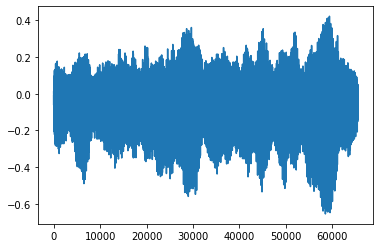

In [27]:
plt.plot(np.squeeze(gen_y[0]))

## Discriminator

### Discriminator Block

In [28]:
def discriminator_block(x):
    # TODO: Ouput feature maps
    x = tfa.layers.WeightNormalization(tf.keras.layers.Conv1D(16, 15, padding="same"), data_init=False)(x)
    fmap_1 = tf.keras.layers.LeakyReLU()(x)
    # Check effect of stride here
    x = tfa.layers.WeightNormalization(tf.keras.layers.Conv1D(64, 41, groups=4, strides=4, padding="same"), data_init=False)(fmap_1)
    fmap_2 = tf.keras.layers.LeakyReLU()(x)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Conv1D(256, 41, groups=16, strides=4, padding="same"), data_init=False)(fmap_2)
    fmap_3 = tf.keras.layers.LeakyReLU()(x)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Conv1D(1024, 41, groups=64, strides=4, padding="same"), data_init=False)(fmap_3)
    fmap_4 = tf.keras.layers.LeakyReLU()(x)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Conv1D(1024, 41, groups=256, strides=4, padding="same"), data_init=False)(fmap_4)
    fmap_5 = tf.keras.layers.LeakyReLU()(x)
    x = tfa.layers.WeightNormalization(tf.keras.layers.Conv1D(1024, 5, strides=1, padding="same"), data_init=False)(fmap_5)
    fmap_6 = tf.keras.layers.LeakyReLU()(x)
    output = tfa.layers.WeightNormalization(tf.keras.layers.Conv1D(1, 3, strides=1, padding="same"), data_init=False)(fmap_6)
    return [fmap_1, fmap_2, fmap_3, fmap_4, fmap_5, fmap_6, output]

### Discriminator Model

In [29]:
def create_discriminator(in_shape):
    d_in = tf.keras.Input(shape=in_shape)
    d1_outputs = discriminator_block(d_in)
    ds2x = tf.keras.layers.AveragePooling1D(pool_size=4, strides=2, padding="same")(d_in)
    d2_outputs = discriminator_block(ds2x)
    ds4x = tf.keras.layers.AveragePooling1D(pool_size=4, strides=4, padding="same")(ds2x)
    d3_outputs = discriminator_block(ds4x)
    return tf.keras.Model(d_in, outputs=[d1_outputs, d2_outputs, d3_outputs], name="discriminator")

In [30]:
in_shape = (None, 1)

In [73]:
discriminator = create_discriminator(in_shape)

In [74]:
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 average_pooling1d_4 (AveragePo  (None, None, 1)     0           ['input_5[0][0]']                
 oling1D)                                                                                         
                                                                                                  
 average_pooling1d_5 (AveragePo  (None, None, 1)     0           ['average_pooling1d_4[0][0]']    
 oling1D)                                                                                         
                                                                                      

### Discriminator forward with Mini Batch

In [33]:
for audio_mb in toy_dataset.take(1):
    x_mb, y_mb = audio_mb
    dreal_outputs = discriminator(x_mb[tf.newaxis, :])

In [34]:
dis_out_shapes = [di_out_j.shape for di in dreal_outputs for di_out_j in di ]
dis_out_shapes

[TensorShape([1, 65536, 16]),
 TensorShape([1, 16384, 64]),
 TensorShape([1, 4096, 256]),
 TensorShape([1, 1024, 1024]),
 TensorShape([1, 256, 1024]),
 TensorShape([1, 256, 1024]),
 TensorShape([1, 256, 1]),
 TensorShape([1, 32768, 16]),
 TensorShape([1, 8192, 64]),
 TensorShape([1, 2048, 256]),
 TensorShape([1, 512, 1024]),
 TensorShape([1, 128, 1024]),
 TensorShape([1, 128, 1024]),
 TensorShape([1, 128, 1]),
 TensorShape([1, 8192, 16]),
 TensorShape([1, 2048, 64]),
 TensorShape([1, 512, 256]),
 TensorShape([1, 128, 1024]),
 TensorShape([1, 32, 1024]),
 TensorShape([1, 32, 1024]),
 TensorShape([1, 32, 1])]

In [35]:
fake_audio_mb = np.random.random((1, DESIRED_SAMPLES, 1))
dfake_outputs = discriminator(fake_audio_mb)

In [36]:
dis_out_shapes = [di_out_j.shape for di in dfake_outputs for di_out_j in di ]
dis_out_shapes

[TensorShape([1, 65536, 16]),
 TensorShape([1, 16384, 64]),
 TensorShape([1, 4096, 256]),
 TensorShape([1, 1024, 1024]),
 TensorShape([1, 256, 1024]),
 TensorShape([1, 256, 1024]),
 TensorShape([1, 256, 1]),
 TensorShape([1, 32768, 16]),
 TensorShape([1, 8192, 64]),
 TensorShape([1, 2048, 256]),
 TensorShape([1, 512, 1024]),
 TensorShape([1, 128, 1024]),
 TensorShape([1, 128, 1024]),
 TensorShape([1, 128, 1]),
 TensorShape([1, 8192, 16]),
 TensorShape([1, 2048, 64]),
 TensorShape([1, 512, 256]),
 TensorShape([1, 128, 1024]),
 TensorShape([1, 32, 1024]),
 TensorShape([1, 32, 1024]),
 TensorShape([1, 32, 1])]

## Losses

### Feature Match

In [37]:
from tensorflow.keras.losses import MeanAbsoluteError

The Generator is trained with feature matching. This objective minimizes the $L_{1}$ distance between the discriminator feature maps of real and fake audio

$D_{k}$ where $k=1,2,3$ 

$D^{(i)}_{k} = i^{th}$ layer feature map of the $k^{th}$ discriminator block



In [38]:
mae = MeanAbsoluteError()

In [39]:
def feature_matching_loss(dfake_outputs, dreal_outputs):
    num_dblocks = len(dfake_outputs)
    # Loss over feature maps only
    num_featmaps = len(dfake_outputs[0]) - 1 
    block_loss = []
    for k in range(num_dblocks):
        featmap_loss = [mae(dreal_outputs[k][i], dfake_outputs[k][i]) for i in range(num_featmaps)]
        block_loss.append(tf.reduce_mean(featmap_loss))
    loss_val = tf.reduce_sum(block_loss)
    return loss_val

In [40]:
feat_matching_loss = feature_matching_loss(dfake_outputs, dreal_outputs)

## Generator Loss

$\min E_{s, z}[\sum_{k=1,2,3} -D_{k}(G(s,z))]$

$\min E_{s, z}\left[-D_{1}\left(G(s,z)\right) -D_{2}\left(G(s,z)\right)-D_{3}\left(G(s,z)\right)\right]$. 

$\min\left(-E_{s, z}[D_{1}\left(G(s,z)\right)] -E_{s, z}[D_{2}\left(G(s,z)\right)]-E_{s, z}[D_{3}\left(G(s,z)\right)]\right)$



In [41]:
for d_out_i in dfake_outputs[0]:
    print(d_out_i.shape)

(1, 65536, 16)
(1, 16384, 64)
(1, 4096, 256)
(1, 1024, 1024)
(1, 256, 1024)
(1, 256, 1024)
(1, 256, 1)


In [87]:
def gen_loss(dfake_outputs):
  return tf.reduce_sum([-1.*tf.reduce_mean(d_k_o[-1]) for d_k_o in dfake_outputs])
  # return -1.*tf.reduce_mean([tf.reduce_sum(d_k[-1]) for d_k in dk_outputs])

In [88]:
gen_loss_val = gen_loss(dfake_outputs)
gen_loss_val

<tf.Tensor: shape=(), dtype=float32, numpy=-6.344232e-05>

In [89]:
# Posibly another definition
tf.reduce_sum([-1.*tf.reduce_mean(d_k_o[-1]) for d_k_o in dfake_outputs])

<tf.Tensor: shape=(), dtype=float32, numpy=-6.344232e-05>

## Discriminator Loss

In [90]:
loss_dis = 0
for dreal_k_outputs in dreal_outputs:
    loss_dis += tf.reduce_mean(tf.keras.layers.ReLU()(1-dreal_k_outputs[-1]))
loss_dis

<tf.Tensor: shape=(), dtype=float32, numpy=2.9999957>

In [91]:
for dfake_k_outputs in dfake_outputs:
    loss_dis += tf.reduce_mean(tf.keras.layers.ReLU()(1+dfake_k_outputs[-1]))
loss_dis

<tf.Tensor: shape=(), dtype=float32, numpy=6.000059>

In [92]:
def discriminator_loss(dreal_outputs, dfake_outputs):
    loss_real = 0
    loss_fake = 0
    for k in range(len(dreal_outputs)):
        loss_real += tf.reduce_mean(tf.keras.layers.ReLU()(1-dreal_outputs[k][-1]))
        loss_fake += tf.reduce_mean(tf.keras.layers.ReLU()(1+dfake_outputs[k][-1]))
    return loss_real + loss_fake

In [48]:
loss_dis = discriminator_loss(dreal_outputs, dfake_outputs)
loss_dis

<tf.Tensor: shape=(), dtype=float32, numpy=6.000059>

## MELGAN

* **Generator**: Generates audio from spectograms
* **Discriminator**: Discriminates fake and real audio

1. Train Discriminator to detect real and fake audio
2. Train Generator to fool discriminator

In [93]:
class MelGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, **kwargs):
        super(MelGAN, self).__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, optimizer_gen, optimizer_dis, feature_matching_loss, generator_loss, discriminator_loss):
        super(MelGAN, self).compile()
        self.optimizer_gen = optimizer_gen
        self.optimizer_dis = optimizer_dis
        self.feature_matching_loss = feature_matching_loss
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss
        self.gen_loss_metric = tf.keras.metrics.Mean(name="gen_loss")
        self.dis_loss_metric = tf.keras.metrics.Mean(name="dis_loss")
    
    def train_step(self, batch):
        x_batch, y_batch = batch
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Train the Discriminator
            gen_audio = self.generator(x_batch, training=True)
            dfake_outputs = self.discriminator(gen_audio)
            dreal_outputs = self.discriminator(x_batch)
            d_loss = self.discriminator_loss(dreal_outputs, dfake_outputs)
            # Train Generator to fool the discriminator
            feat_match_loss = self.feature_matching_loss(dfake_outputs, dreal_outputs)
            gen_loss = self.generator_loss(dfake_outputs)
            final_gen_loss = gen_loss + 10.*feat_match_loss
        
        d_grads = disc_tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.optimizer_dis.apply_gradients(zip(d_grads, self.discriminator.trainable_weights))
        g_grads = gen_tape.gradient(final_gen_loss, self.generator.trainable_weights)
        self.optimizer_gen.apply_gradients(zip(g_grads, self.generator.trainable_weights))
        
        self.gen_loss_metric.update_state(final_gen_loss)
        self.dis_loss_metric.update_state(d_loss)
        
        return {
            "gen_loss": self.gen_loss_metric.result(),
            "disc_loss": self.dis_loss_metric.result(),
        }   

In [94]:
tf.random.set_seed(42)

in_shape = (None, 1)
generator = get_generator(in_shape)
in_shape = (None, 1)
discriminator = create_discriminator(in_shape)

In [95]:
mel_gan = MelGAN(generator, discriminator)

In [96]:
LEARNING_RATE_GEN = 1e-5
LEARNING_RATE_DISC = 1e-6
gen_optimizer = tf.keras.optimizers.Adam(
    LEARNING_RATE_GEN, beta_1=0.5, beta_2=0.9, clipnorm=1
)
disc_optimizer = tf.keras.optimizers.Adam(
    LEARNING_RATE_DISC, beta_1=0.5, beta_2=0.9, clipnorm=1
)

In [97]:
mel_gan.compile(gen_optimizer, disc_optimizer, feature_matching_loss, gen_loss, discriminator_loss)

## Overfit Toy DataSet

In [98]:
BATCH_SIZE = 4
history = mel_gan.fit(toy_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE), epochs=2000, verbose=1)

Epoch 1/2000
1/1 [==============================] - 33s 33s/step - gen_loss: 0.1770 - disc_loss: 6.0000
Epoch 2/2000
1/1 [==============================] - 0s 448ms/step - gen_loss: 0.1600 - disc_loss: 6.0000
Epoch 3/2000
1/1 [==============================] - 0s 447ms/step - gen_loss: 0.1445 - disc_loss: 5.9999
Epoch 4/2000
1/1 [==============================] - 0s 449ms/step - gen_loss: 0.1306 - disc_loss: 5.9999
Epoch 5/2000
1/1 [==============================] - 0s 448ms/step - gen_loss: 0.1187 - disc_loss: 5.9999
Epoch 6/2000
1/1 [==============================] - 0s 448ms/step - gen_loss: 0.1087 - disc_loss: 5.9999
Epoch 7/2000
1/1 [==============================] - 0s 446ms/step - gen_loss: 0.1010 - disc_loss: 5.9999
Epoch 8/2000
1/1 [==============================] - 0s 446ms/step - gen_loss: 0.0956 - disc_loss: 5.9999
Epoch 9/2000
1/1 [==============================] - 0s 445ms/step - gen_loss: 0.0920 - disc_loss: 6.0000
Epoch 10/2000
1/1 [==============================] - 0s 

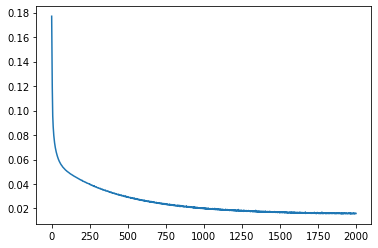

In [99]:
history.history.keys()
plt.plot(history.history['gen_loss'])
plt.show();

## Inference

1. Create some spectograms
2. Use Generator for audio inversion

In [100]:
for audio_mb in toy_dataset.batch(BATCH_SIZE).take(1):
    x_batch, y_batch = audio_mb
    spectograms = mel_layer(x_batch)
spectograms.shape

TensorShape([4, 256, 80])

In [101]:
gen_audio = mel_gan.generator.predict(spectograms)
gen_audio.shape

(4, 65536, 1)

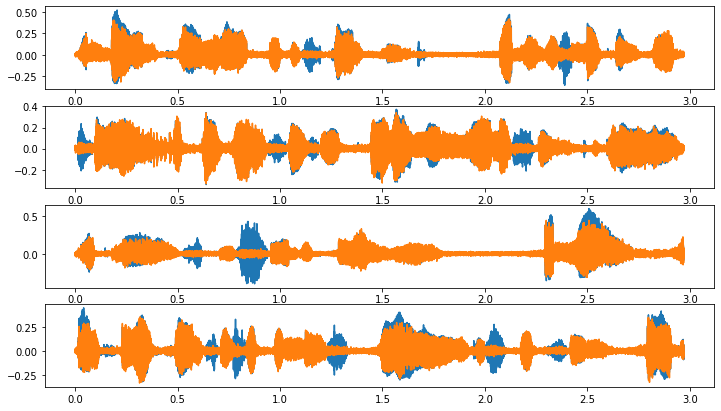

In [102]:
t = np.arange(0, DESIRED_SAMPLES/sample_rate, 1/sample_rate)
plt.figure(figsize=(12, 7))
plt.subplot(411)
plt.plot(t, np.squeeze(x_batch[0]))
plt.plot(t, np.squeeze(gen_audio[0]))
plt.subplot(412)
plt.plot(t, np.squeeze(x_batch[1]))
plt.plot(t, np.squeeze(gen_audio[1]))
plt.subplot(413)
plt.plot(t, np.squeeze(x_batch[2]))
plt.plot(t, np.squeeze(gen_audio[2]))
plt.subplot(414)
plt.plot(t, np.squeeze(x_batch[3]))
plt.plot(t, np.squeeze(gen_audio[3]))
plt.show();

In [103]:
Audio(np.squeeze(gen_audio[0]), rate=sample_rate)

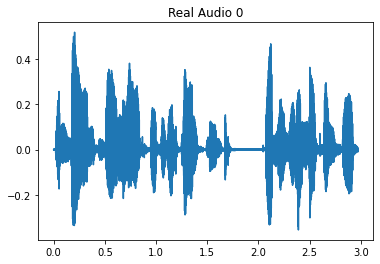

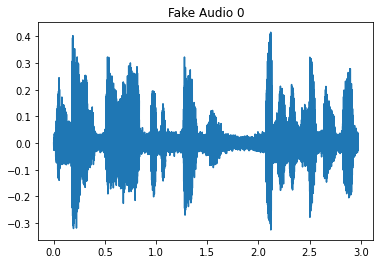

In [104]:
k = 0
plt.figure()
plt.plot(t, np.squeeze(x_batch[k]))
plt.title(f"Real Audio {k}")
plt.show();
plt.figure()
plt.plot(t, np.squeeze(gen_audio[k]))
plt.title(f"Fake Audio {k}")
plt.show();

In [105]:
y_batch.shape

TensorShape([4, 65536, 1])

In [62]:
# y_batch
# y_gl = tfio.audio.inverse_spectrogram(tf.squeeze(spectograms[0]), )

### Griffin-Lim

In [63]:
import librosa.display
import matplotlib.pyplot as plt

In [106]:
stfts = tf.signal.stft(tf.squeeze(x_batch, -1), 
                       frame_length=1024, 
                       frame_step=256, 
                       pad_end=True)
stfts = tf.abs(stfts)
stfts = tf.transpose(stfts, perm=[0,2,1])

In [107]:
stfts.shape

TensorShape([4, 513, 256])

In [108]:
index = 0
y_inv = librosa.griffinlim(stfts[index,:].numpy())
#Audio(np.squeeze(y_inv[index]), rate=sample_rate)

In [109]:
Audio(np.squeeze(y_inv), rate=sample_rate)

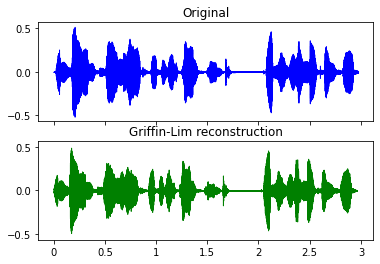

In [110]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
librosa.display.waveshow(np.squeeze(x_batch[index].numpy()), sr=sample_rate, color='b', ax=ax[0])
ax[0].set(title='Original', xlabel=None)
ax[0].label_outer()
librosa.display.waveshow(y_inv, sr=sample_rate, color='g', ax=ax[1])
ax[1].set(title='Griffin-Lim reconstruction', xlabel=None)
ax[1].label_outer()